In [3]:
USE_GPU = False
from typing import List, Tuple, Dict, Any, Optional
import seaborn as sns
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import statsmodels.api as sm
import re
import plotly.express as px
import pandas as pd
import numpy as np
import seaborn as sns
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
import os
import glob
from typing import Dict
from statsmodels.tsa.filters.hp_filter import hpfilter
import re
from datetime import datetime
import plotly
import plotly.offline as pyo
import plotly.io as pio

from plotly.subplots import make_subplots
import numpy.linalg as la

import plotly.graph_objects as go

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('mode.chained_assignment', None)
pio.renderers.default = 'notebook+pdf'

PLOTLY_COLORS = plotly.colors.DEFAULT_PLOTLY_COLORS

from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingRegressor
np.random.seed(42)

SEGMENTS = [
    'DQN Small Q1',
    'DQN Small Q2',
    'DQN Medium Q1',
    'DQN Medium Q2',
    'DQN Large Q1',
    'DQN Large Q2',
    'DQN Max Q1',
    'DQN Max Q2',
]


In [54]:
def session_size_bin(x):
    if x <= 20:
        return 'small'
    
    elif x <= 40:
        return 'medium'
    elif x <= 60:
        return 'large'
    else:
        return 'max'

def filter_and_norm(x):
    dist_container = []
    if x['inc_small'] > 0:
        dist_container.append(x['inc_small'])
    
    if x['inc_medium'] > 0:
        dist_container.append(x['inc_medium'] - x['inc_small'])
    
    if x['inc_large'] > 0:
        dist_container.append(x['inc_large'] - x['inc_medium'])
        
    return la.norm(dist_container) / len(dist_container)

def feature_importance(subset, feature_cols, target_col, sim, sub_name):
    model = GradientBoostingRegressor(random_state=42)
    features, target = subset[feature_cols], subset[target_col]
    model.fit(features, target)
    mean_importances = permutation_importance(model, features, target, random_state=42, n_repeats=10).importances_mean
    return [
    {
        "feature_name": feature,
        "importance": importance,
        "sim": sim,
        "sub_name": sub_name
    }
    for feature, importance in zip(feature_cols, mean_importances)
    ]

In [30]:
df_q1_dqn, df_q2_dqn = pd.read_parquet('dqn_parquet/eval/dqn_pred_cnn_15000_no_pen.parquet'), pd.read_parquet('dqn_parquet/eval/q2/dqn_pred_cnn_15000.parquet')

In [21]:
df_q1_dqn['size_segment'] = df_q1_dqn['session_size'].apply(session_size_bin)
df_q1_dqn['question'] = 'q1'
df_q2_dqn['size_segment'] = df_q2_dqn['session_size'].apply(session_size_bin)
df_q2_dqn['question'] = 'q2'

In [22]:
small_df_q1, small_df_q2 = df_q1_dqn[df_q1_dqn['size_segment'] == 'small'], df_q2_dqn[df_q2_dqn['size_segment'] == 'small']
medium_df_q1, medium_df_q2 = df_q1_dqn[df_q1_dqn['size_segment'] == 'medium'], df_q2_dqn[df_q2_dqn['size_segment'] == 'medium']
large_df_q1, large_df_q2 = df_q1_dqn[df_q1_dqn['size_segment'] == 'large'], df_q2_dqn[df_q2_dqn['size_segment'] == 'large']
max_df_q1, max_df_q2 = df_q1_dqn[df_q1_dqn['size_segment'] == 'max'], df_q2_dqn[df_q2_dqn['size_segment'] == 'max']

In [23]:
small_df_q1['norm_inc'] = small_df_q1[['inc_small', 'inc_medium', 'inc_large']].apply(lambda x: filter_and_norm(x), axis=1)
small_df_q2['norm_inc'] = small_df_q2[['inc_small', 'inc_medium', 'inc_large']].apply(lambda x: filter_and_norm(x), axis=1)

medium_df_q1['norm_inc'] = medium_df_q1[['inc_small', 'inc_medium', 'inc_large']].apply(lambda x: filter_and_norm(x), axis=1)
medium_df_q2['norm_inc'] = medium_df_q2[['inc_small', 'inc_medium', 'inc_large']].apply(lambda x: filter_and_norm(x), axis=1)

large_df_q1['norm_inc'] = large_df_q1[['inc_small', 'inc_medium', 'inc_large']].apply(lambda x: filter_and_norm(x), axis=1)
large_df_q2['norm_inc'] = large_df_q2[['inc_small', 'inc_medium', 'inc_large']].apply(lambda x: filter_and_norm(x), axis=1)

max_df_q1['norm_inc'] = max_df_q1[['inc_small', 'inc_medium', 'inc_large']].apply(lambda x: filter_and_norm(x), axis=1)
max_df_q2['norm_inc'] = max_df_q2[['inc_small', 'inc_medium', 'inc_large']].apply(lambda x: filter_and_norm(x), axis=1)


In [24]:
segment_container = []
for segment, df in zip(SEGMENTS, [small_df_q1, small_df_q2, medium_df_q1, medium_df_q2, large_df_q1, large_df_q2, max_df_q1, max_df_q2]):
    segment_container.append({
        'size': df['size_segment'].unique()[0],
        'question': df['question'].iloc[0],
        'norm': df['norm_inc'].mean(),
        'subset': segment
    })


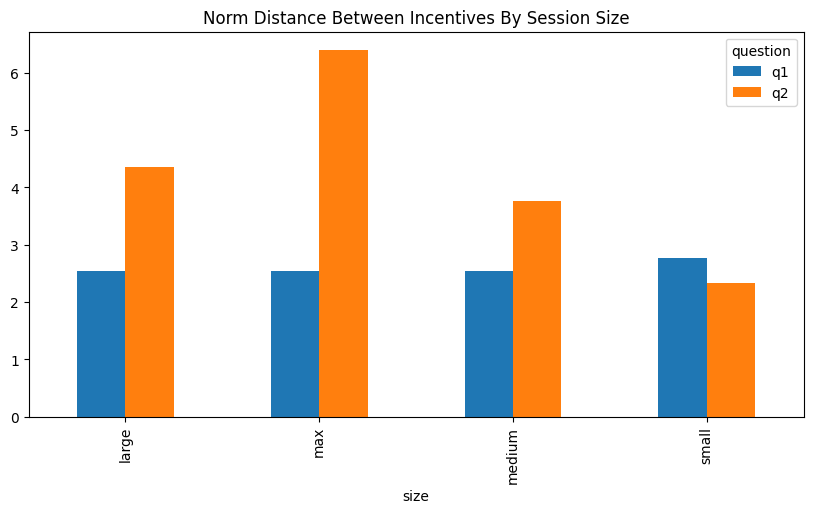

In [25]:
df_done = pd.DataFrame(segment_container)
fig = df_done.pivot(index='size', columns='question', values='norm').plot(kind='bar', figsize=(10, 5), title='Norm Distance Between Incentives By Session Size')
plt.savefig('rl_plots/q2/norm_distance_by_session_size.png')

In [26]:
q1_cols = ['inc_small', 'inc_medium', 'inc_large']
q2_cols = ['inc_small', 'inc_medium', 'inc_large'] + [col for col in small_df_q2.columns if 'soc' in col and '189' not in col]

In [27]:
small_df_q1.head()

,session_size,session_minutes,size_cutoff,time_cutoff,reward,ended,inc_small,time_small,inc_medium,time_medium,inc_large,time_large,ended_event,ended_time,exp_runs,size_segment,question,norm_inc
2,18,25.333333,9,7.30,0.0,0,2,0.983333,9,7.300000,6,4.850000,16,22.800000,2,small,q1,2.624669
3,18,25.333333,9,7.30,0.0,0,2,0.983333,9,7.300000,6,4.850000,16,22.800000,2,small,q1,2.624669
4,18,38.250000,9,25.15,0.0,0,2,4.550000,4,15.466667,7,22.350000,10,26.216667,3,small,q1,1.374369
5,18,38.250000,9,25.15,0.0,0,2,4.550000,4,15.466667,7,22.350000,10,26.216667,3,small,q1,1.374369
6,10,8.633333,5,4.05,0.0,0,2,0.283333,0,0.000000,6,5.116667,7,5.966667,4,small,q1,3.162278


In [55]:
importances_q1_container = []
importances_q2_container = []

for subset_q1, subset_name in zip([small_df_q1, medium_df_q1, large_df_q1, max_df_q1], ['small', 'medium', 'large', 'max']):
    importances_q1_container.append(feature_importance(subset_q1, q1_cols, ['ended_event'], "q1", subset_name))

for subset_q2, subset_name in zip([small_df_q2, medium_df_q2, large_df_q2, max_df_q2], ['small', 'medium', 'large', 'max']):
    importances_q2_container.append(feature_importance(subset_q2, q2_cols, ['ended_event'], "q2", subset_name))

/Users/danielmiller/.pyenv/versions/3.9.15/envs/torch_rl/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/danielmiller/.pyenv/versions/3.9.15/envs/torch_rl/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/danielmiller/.pyenv/versions/3.9.15/envs/torch_rl/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/danielmiller/.pyenv/versions/3.9.15/envs/torch_rl/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning:

A column-vector y was passed when a 1d array w

ValueError: too many values to unpack (expected 2)

In [50]:
df = pd.DataFrame([item for sublist in importances_q1_container for item in sublist])

In [52]:
df.head(100)

,feature_name,importance,sim
0,inc_small,0.000228,q1
1,inc_medium,1.813083,q1
2,inc_large,0.042790,q1
3,inc_small,0.003727,q1
4,inc_medium,0.216403,q1
5,inc_large,0.065379,q1
6,inc_small,0.004596,q1
7,inc_medium,0.092321,q1
8,inc_large,0.043712,q1
9,inc_small,0.017109,q1
